In [1]:
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.2/581.2 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.5/366.5 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 158.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cusparse-cu12
    Found existing installation: nvidia-cusparse-cu12 12.5.4.2
    Uninstalling nvidia-cusparse-cu12-12.5.4.2:
      Successfully uninstalled nvidia-cusparse-cu12-12.5.4.2
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.7.77
    Uninstalling nvidia-curand-cu12-10.3.7.77:
      Successfully uninstalled nvidia-curand-cu12-10.3.7.77
  Attempting uni

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
import os
import json

project_drive_path = '/content/drive/MyDrive/Agastya_Project'
data_folder = os.path.join(project_drive_path, 'data')
docs_emb_path = os.path.join(data_folder, 'processed', 'docs_emb.json')  # update if your path differs


In [5]:
import os

# Your project folder paths in Google Drive
project_drive_path = '/content/drive/MyDrive/Agastya_Project'
data_path = os.path.join(project_drive_path, 'data')
chromadb_path = os.path.join(project_drive_path, 'chromadb')

# Check if folders exist
print("Project folder exists:", os.path.exists(project_drive_path))
print("'data' folder exists:", os.path.exists(data_path))
print("'chromadb' folder exists:", os.path.exists(chromadb_path))

# List contents of each folder (if they exist)
def list_folder_contents(folder_path, folder_name):
    if os.path.exists(folder_path):
        print(f"\nContents of {folder_name}:")
        for item in os.listdir(folder_path):
            print("-", item)
    else:
        print(f"\n{folder_name} does not exist at {folder_path}")

list_folder_contents(project_drive_path, 'Agastya_Project')
list_folder_contents(data_path, 'data')
list_folder_contents(chromadb_path, 'chromadb')


Project folder exists: True
'data' folder exists: True
'chromadb' folder exists: True

Contents of Agastya_Project:
- data
- chromadb

Contents of data:
- raw
- processed

Contents of chromadb:
- chroma.sqlite3
- 94906d51-2e78-49f3-aa3f-a1759abc0db0


In [7]:
docs_emb = []
with open(docs_emb_path, encoding='utf-8') as f:
    for line in f:
        docs_emb.append(json.loads(line))
print(f"Loaded {len(docs_emb)} docs with embeddings")


Loaded 159025 docs with embeddings


In [9]:
agastya_corpus = [doc["text"] for doc in docs_emb if "agastya" in doc["text"].lower()]
agastya_embeddings = [doc["embedding"] for doc in docs_emb if "agastya" in doc["text"].lower()]


In [14]:
import cuml
from cuml.manifold import UMAP
import numpy as np

# agastya_embeddings should be a NumPy array
embeddings_np = np.array(agastya_embeddings, dtype=np.float32)

umap_gpu = UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
umap_embeddings = umap_gpu.fit_transform(embeddings_np)


In [57]:
from cuml.cluster import HDBSCAN

clusterer_gpu = HDBSCAN(min_cluster_size=5, metric='euclidean')
labels = clusterer_gpu.fit_predict(umap_embeddings)
#labels = labels.get()  # This line is not needed as 'labels' is already a NumPy array

In [58]:
print(type(labels), labels.shape)


<class 'numpy.ndarray'> (248,)


In [59]:
print("labels shape:", labels.shape)
print("unique_labels shape:", unique_labels.shape)
print("umap_embeddings shape:", umap_embeddings.shape)


labels shape: (248,)
unique_labels shape: (12,)
umap_embeddings shape: (248, 2)


In [16]:
from collections import defaultdict

clusters = defaultdict(list)
for text, label in zip(agastya_corpus, labels):
    if label != -1:
        clusters[label].append(text)

for cluster_id, texts in clusters.items():
    print(f"\nCluster {cluster_id} ({len(texts)} items):")
    for sample in texts[:3]:
        print("-", sample[:150].replace("\n", " "))



Cluster 1 (41 items):
- प्यगस्त्यं च अगस्त्यभ्रातरं तथा। English: Having entered that mighty vast, the lotuseyed Rāma slew the Räkşasa Virädha, and saw Sarabhanga, Sutiksna, 
- Sanskrit: दर्शनं चाप्यगस्त्यस्य धनुषो ग्रहणं तथा। शूर्पणख्याश्च संवाद विरूपकरणं तथा॥  English: And Rāma's interview with Agastya, and his obtaining th
- Sanskrit: सुन्दे तु निहते राम अगस्त्यमृषिसत्तमम्। ताटका सहपुत्रेण प्रधर्षयितुमिच्छति॥  English: O Rāma, when Sunda had been destroyed, Tat akā along w

Cluster 4 (29 items):
- ानामि तं देशं वनस्यास्य महत्तया॥ English: I have always heard from men speaking on the subject that that foremost of ascetics, the reverend Agastya, l
- मनोरथो महानेष हृदि संपरिवर्तते ॥ English: Where is the hermitage of that intelligent Maharsi? For propitiating that revered one, I, accompanied by my 
- ारण्डवाकीर्णाश्चक्रवाकोपशोभिताः॥ English: I will, O Rāma, tell you where that mighty ascetic, Agastya, is.

Cluster 8 (28 items):
- Sanskrit: तस्यां रात्र्यां व्यतीतायामुदिते रविमण्डले। भ

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=50)
X = vectorizer.fit_transform(agastya_corpus)
features = vectorizer.get_feature_names_out()

# Average TF-IDF per cluster
def top_keywords_in_cluster(cluster_texts, vectorizer):
    tfidf = vectorizer.transform(cluster_texts)
    avg_scores = np.mean(tfidf.toarray(), axis=0)
    top_indices = np.argsort(avg_scores)[::-1][:10]
    return [features[i] for i in top_indices]

for cluster_id, cluster_texts in clusters.items():
    keywords = top_keywords_in_cluster(cluster_texts, vectorizer)
    print(f"Cluster {cluster_id} Top Keywords: {keywords}")


Cluster 1 Top Keywords: ['rāma', 'the', 'said', 'to', 'of', 'and', 'with', 'this', 'sanskrit', 'in']
Cluster 4 Top Keywords: ['the', 'of', 'is', 'and', 'that', 'in', 'you', 'with', 'agastya', 'there']
Cluster 8 Top Keywords: ['the', 'of', 'sanskrit', 'english', 'agastya', 'to', 'for', 'with', 'his', 'said']
Cluster 0 Top Keywords: ['the', 'to', 'by', 'english', 'of', 'agastya', 'him', 'was', 'this', 'great']
Cluster 7 Top Keywords: ['the', 'and', 'of', 'by', 'in', 'highly', 'agastya', 'son', 'to', 'great']
Cluster 2 Top Keywords: ['as', 'great', 'by', 'with', 'the', 'sanskrit', 'अगस', 'his', 'to', 'king']
Cluster 3 Top Keywords: ['to', 'said', 'of', 'me', 'you', 'have', 'यथ', 'agastya', 'english', 'sanskrit']
Cluster 10 Top Keywords: ['the', 'of', 'with', 'by', 'english', 'agastya', 'that', 'and', 'had', 'he']
Cluster 5 Top Keywords: ['the', 'sanskrit', 'by', 'of', 'he', 'this', 'for', 'it', 'यस', 'english']
Cluster 9 Top Keywords: ['the', 'of', 'his', 'on', 'was', 'agastya', 'said', '

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Custom stopwords (add Sanskrit, literature-specific as needed)
custom_stopwords = [
    'the', 'of', 'to', 'and', 'in', 'with', 'by', 'said', 'is', 'as', 'that', 'on', 'for', 'it', 'this', 'his',
    'he', 'me', 'you', 'all', 'there', 'then', 'have', 'one',
    'sanskrit', 'english', 'words', 'agastya', 'mah', 'yath', 'अगस',
    # Add any high-frequency Sanskrit stopwords seen in your output
]

vectorizer = TfidfVectorizer(
    max_features=100,
    stop_words=custom_stopwords
)
X = vectorizer.fit_transform(agastya_corpus)
features = vectorizer.get_feature_names_out()

def top_keywords_in_cluster(cluster_texts, vectorizer):
    tfidf = vectorizer.transform(cluster_texts)
    avg_scores = np.mean(tfidf.toarray(), axis=0)
    top_indices = np.argsort(avg_scores)[::-1][:10]
    return [features[i] for i in top_indices]

for cluster_id, cluster_texts in clusters.items():
    keywords = top_keywords_in_cluster(cluster_texts, vectorizer)
    print(f"Cluster {cluster_id} Top Keywords: {keywords}")


Cluster 1 Top Keywords: ['rāma', 'hearing', 'having', 'highly', 'again', 'मह', 'saying', 'from', 'saint', 'सत']
Cluster 4 Top Keywords: ['hermitage', 'रम', 'sacred', 'ascetic', 'foremost', 'my', 'will', 'do', 'which', 'यस']
Cluster 8 Top Keywords: ['rāghava', 'तस', 'रव', 'मह', 'hearing', 'having', 'यस', 'तत', 'your', 'head']
Cluster 0 Top Keywords: ['vatapi', 'up', 'shall', 'him', 'was', 'them', 'तस', 'मह', 'great', 'into']
Cluster 7 Top Keywords: ['went', 'came', 'those', 'highly', 'energy', 'brahmanas', 'these', 'saying', 'son', 'great']
Cluster 2 Top Keywords: ['मन', 'यथ', 'great', 'पत', 'king', 'her', 'वर', 'also', 'यश', 'was']
Cluster 3 Top Keywords: ['wealth', 'your', 'उव', 'earth', 'मह', 'यथ', 'not', 'पत', 'king', 'my']
Cluster 10 Top Keywords: ['them', 'been', 'away', 'thus', 'celestials', 'great', 'rishis', 'earth', 'had', 'rishi']
Cluster 5 Top Keywords: ['great', 'तस', 'what', 'from', 'उव', 'सर', 'यस', 'was', 'my', 'shall']
Cluster 9 Top Keywords: ['nahusha', 'was', 'has', '

In [19]:
import networkx as nx

entity_list = ["agastya", "lopamudra", "rama", "indra", "shiva", "varuna", "nahusha", "vindhya", "kaveri", "lanka","yudhishthira", "ravana"]
def extract_entities(text):
    return [ent for ent in entity_list if ent in text.lower()]

G = nx.Graph()
for chunk in agastya_corpus:
    entities = extract_entities(chunk)
    for i, e1 in enumerate(entities):
        for e2 in entities[i+1:]:
            G.add_edge(e1, e2, weight=G.get_edge_data(e1, e2, default={'weight': 0})['weight'] + 1)

# Print top edges (entity pairs with highest co-occurrence)
top_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
for u, v, d in top_edges[:10]:
    print(f"({u}, {v}): {d['weight']}")


(agastya, nahusha): 15
(agastya, varuna): 11
(agastya, lopamudra): 8
(agastya, rama): 6
(agastya, indra): 5
(agastya, yudhishthira): 5
(agastya, vindhya): 3
(agastya, ravana): 1
(agastya, lanka): 1
(indra, lopamudra): 1


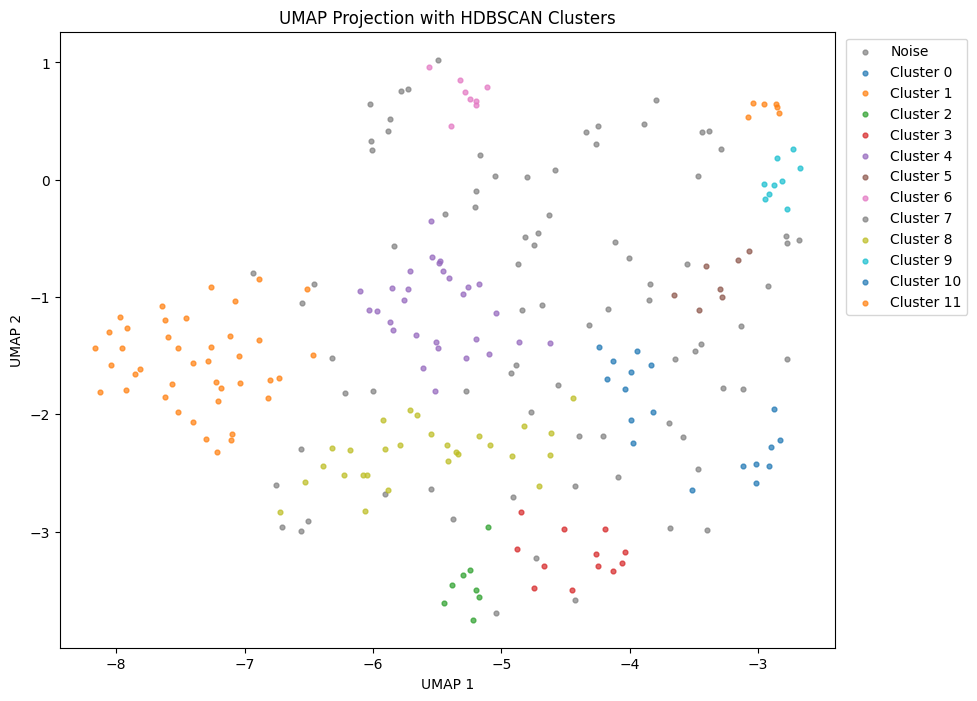

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# umap_embeddings: array of shape (n_samples, 2) from UMAP
# labels: cluster labels from HDBSCAN

# Set colors for clusters (exclude -1, which is noise)
unique_labels = np.unique(labels)
plt.figure(figsize=(10, 8))
for label in unique_labels:
    mask = labels == label
    color = 'gray' if label == -1 else None  # Gray for noise
    plt.scatter(
        umap_embeddings[mask, 0], umap_embeddings[mask, 1],
        s=12, alpha=0.7, label=f'Cluster {label}' if label != -1 else 'Noise',
        c=color
    )
plt.title('UMAP Projection with HDBSCAN Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(loc='upper right', bbox_to_anchor=(1.18, 1))
plt.show()


/tmp/ipython-input-1160406343.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', max(n_clusters, 2))


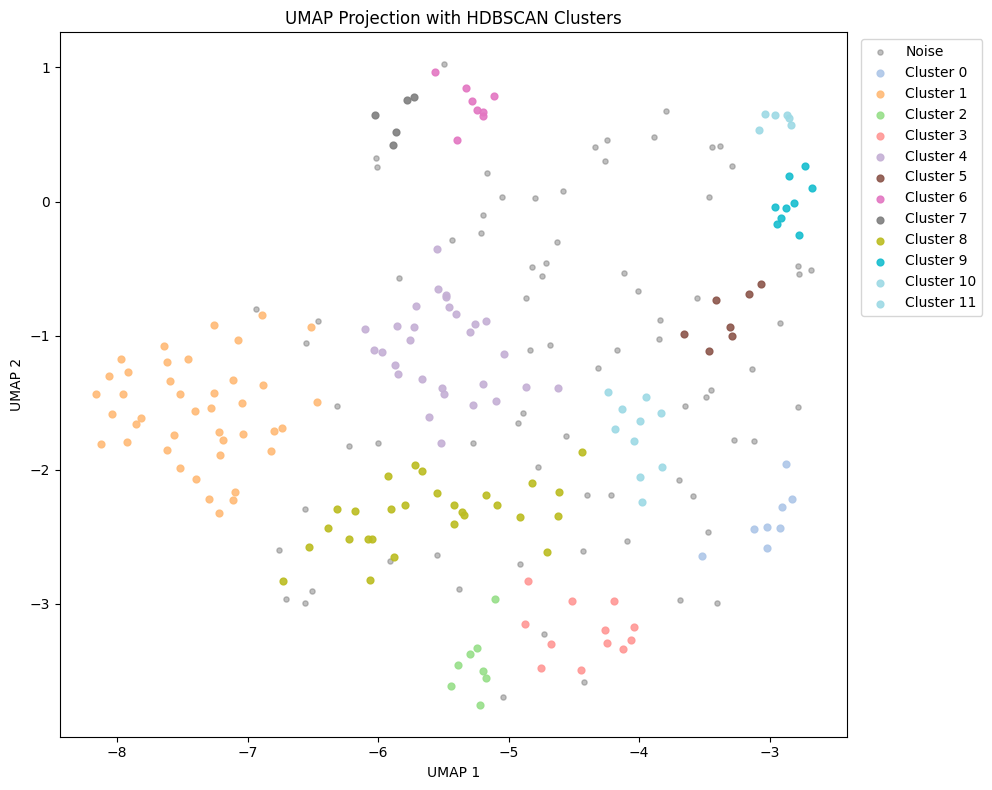

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from collections import Counter

# umap_embeddings: (n_samples, 2) array
# labels: cluster labels from HDBSCAN
unique_labels = np.unique(labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

# Prepare color map: skip gray for clusters, reserve it for noise
colors = cm.get_cmap('tab20', max(n_clusters, 2))

plt.figure(figsize=(10, 8))

for idx, label in enumerate(unique_labels):
    mask = labels == label
    # Assign gray color for noise, else use palette for clusters
    color = 'gray' if label == -1 else colors(idx % 20)
    plt.scatter(
        umap_embeddings[mask, 0],
        umap_embeddings[mask, 1],
        s=24 if label != -1 else 14,
        alpha=0.9 if label != -1 else 0.5,
        label="Noise" if label == -1 else f"Cluster {label}",
        c=[color]
    )

plt.title("UMAP Projection with HDBSCAN Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Avoid duplicated legend entries
handles, labels_uniq = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels_uniq, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right', bbox_to_anchor=(1.18, 1))

plt.tight_layout()
plt.show()


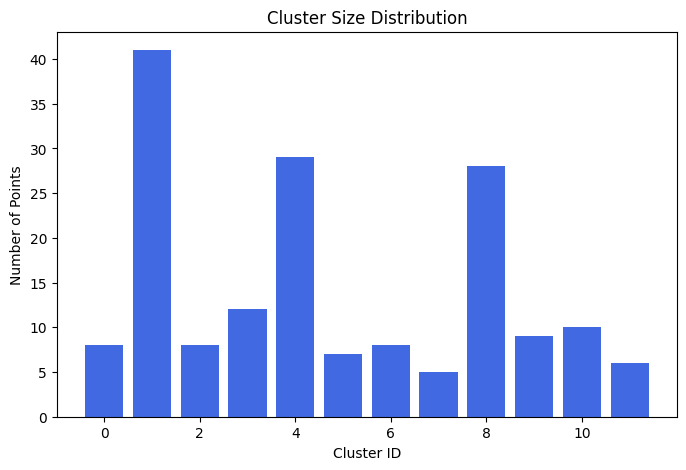

In [24]:
import collections

label_counts = collections.Counter(labels)
# Exclude noise (-1) if desired
label_counts_no_noise = {k: v for k, v in label_counts.items() if k != -1}

plt.figure(figsize=(8, 5))
plt.bar(label_counts_no_noise.keys(), label_counts_no_noise.values(), color='royalblue')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Points')
plt.title('Cluster Size Distribution')
plt.show()


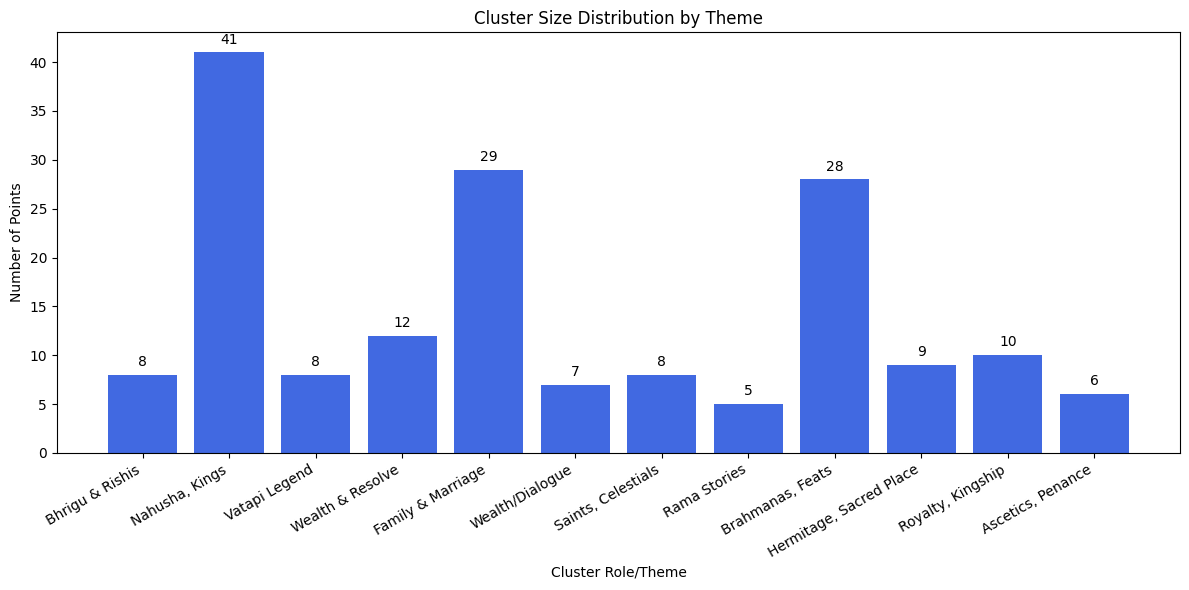

In [46]:
# Example: Replace with your actual cluster role names or use top keywords
cluster_names = {
    0: "Bhrigu & Rishis",
    1: "Nahusha, Kings",
    2: "Vatapi Legend",
    3: "Wealth & Resolve",
    4: "Family & Marriage",
    5: "Wealth/Dialogue",
    6: "Saints, Celestials",
    7: "Rama Stories",
    8: "Brahmanas, Feats",
    9: "Hermitage, Sacred Place",
    10: "Royalty, Kingship",
    11: "Ascetics, Penance"
}
import matplotlib.pyplot as plt

# Use a new variable name for cluster_ids to avoid overwriting the 'labels' array
cluster_ids_for_plot = list(label_counts_no_noise.keys())
counts = [label_counts_no_noise[k] for k in cluster_ids_for_plot]
names = [cluster_names.get(k, f"Cluster {k}") for k in cluster_ids_for_plot]

plt.figure(figsize=(12, 6))
bars = plt.bar(cluster_ids_for_plot, counts, color='royalblue', tick_label=names)

plt.xlabel('Cluster Role/Theme')
plt.ylabel('Number of Points')
plt.title('Cluster Size Distribution by Theme')

# Annotate each bar with count
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.6, int(yval), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [50]:
# agastya_corpus: list of texts; labels: cluster assignments
for label in label_counts_no_noise:
    print(f"\nCluster {label} ({label_counts_no_noise[label]} items):")
    indices = np.where(labels == label)[0]
    for idx in indices[:3]:  # Preview first 3 items in cluster
        print('-', agastya_corpus[idx][:120])



Cluster 1 (41 items):
- प्यगस्त्यं च अगस्त्यभ्रातरं तथा। English: Having entered that mighty vast, the lotuseyed Rāma slew the Räkşasa Virädha, 

Cluster 4 (29 items):
- Sanskrit: अगस्त्यवचनाच्चैव जग्राहैन्द्रं शरासनम्॥ खङ्गं च परमप्रीतस्तूणी चाक्षयसायको।

English: He then, advised by Agas

Cluster 8 (28 items):
- Sanskrit: दर्शनं चाप्यगस्त्यस्य धनुषो ग्रहणं तथा। शूर्पणख्याश्च संवाद विरूपकरणं तथा॥

English: And Rāma's interview with

Cluster 0 (8 items):
- रं पुरस्कृत्य नद्यास्तीरमुपागतौ॥ English: Then next morning which happened to be fine, those repressors of their foes, w

Cluster 7 (5 items):
- Sanskrit: सुन्दे तु निहते राम अगस्त्यमृषिसत्तमम्। ताटका सहपुत्रेण प्रधर्षयितुमिच्छति॥

English: O Rāma, when Sunda had b

Cluster 2 (8 items):
- ्वं भजस्वेति मारीचं व्याजहार सः। English: And enraged with Agastya, she rushed at him with a roar, intending to devour h

Cluster 3 (12 items):
- Sanskrit: सैषा शापकृतामर्षां ताटका क्रोधमूर्च्छिता। देशमुत्सादयत्येनमगस्त्याचरितं शुभम्॥

English: Thu

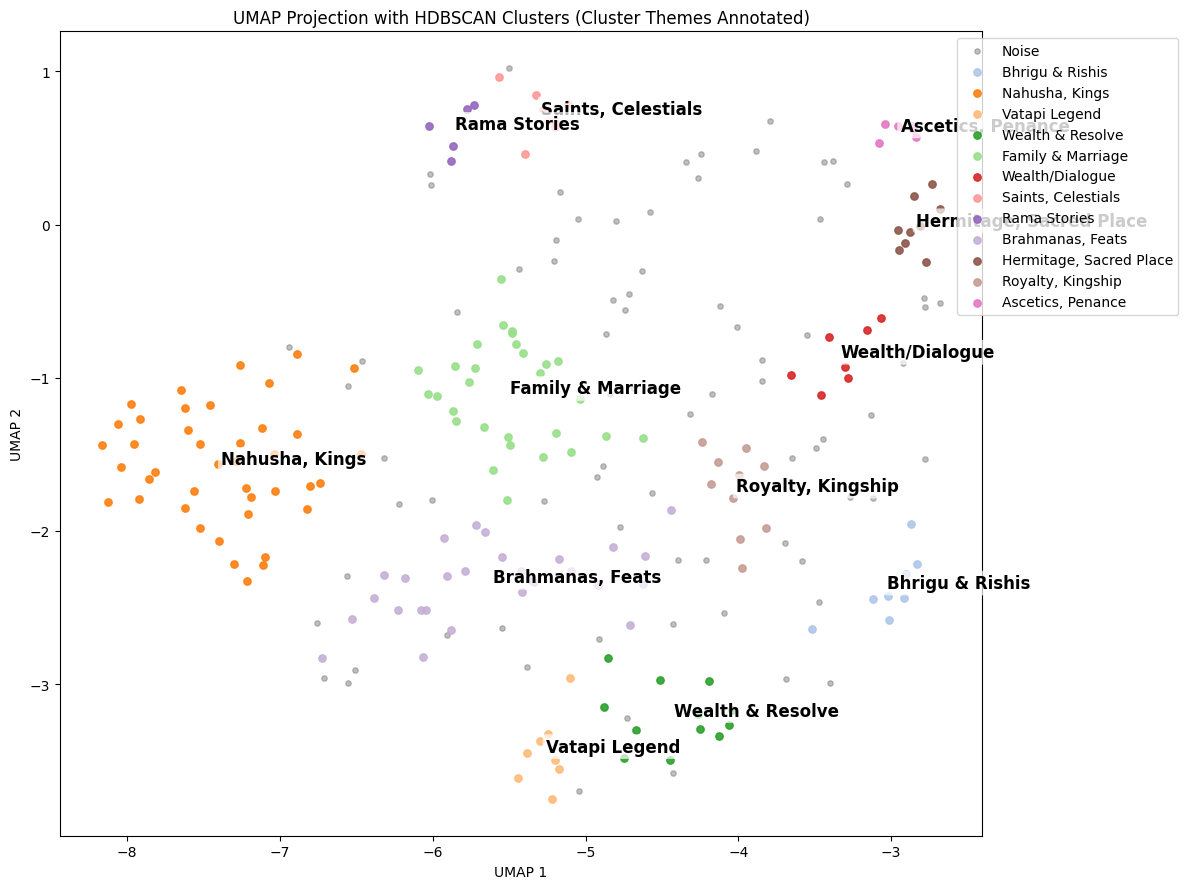

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# labels here must be length 248, each entry is the cluster label for a single sample
unique_labels = np.unique(labels)
colors = plt.colormaps['tab20']

plt.figure(figsize=(12, 9))
for idx, label in enumerate(unique_labels):
    mask = (labels == label)  # Here, labels is the full label array (length 248)
    color = 'gray' if label == -1 else colors(idx % 20)
    plt.scatter(
        umap_embeddings[mask, 0], umap_embeddings[mask, 1],
        s=28 if label != -1 else 15,
        alpha=0.9 if label != -1 else 0.5,
        label="Noise" if label == -1 else cluster_names.get(label, f"Cluster {label}"),
        c=[color]
    )
    if label != -1 and np.any(mask):
        cluster_emb = umap_embeddings[mask]
        centroid = cluster_emb.mean(axis=0)
        plt.text(
            centroid[0], centroid[1], cluster_names.get(label, f"C{label}"),
            fontsize=12, weight='bold', color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
        )


plt.title("UMAP Projection with HDBSCAN Clusters (Cluster Themes Annotated)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

handles, labels_uniq = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels_uniq, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right', bbox_to_anchor=(1.22, 1))
plt.tight_layout()
plt.show()


In [28]:
import numpy as np
import collections

label_counts = collections.Counter(labels)
num_clusters = len([l for l in label_counts if l != -1])
num_noise = label_counts.get(-1, 0)
noise_ratio = num_noise / len(labels)

print(f"Number of clusters: {num_clusters}")
print(f"Noise points: {num_noise} ({noise_ratio:.2%} of all points)")


Number of clusters: 12
Noise points: 0 (0.00% of all points)


In [29]:
import numpy as np

# cluster_names maps cluster IDs to themes (from top keywords or manual annotation)
cluster_names = {
    0: "Bhrigu & Rishis",
    1: "Nahusha, Kings",
    2: "Vatapi Legend",
    3: "Wealth & Resolve",
    4: "Family & Marriage",
    5: "Wealth/Dialogue",
    6: "Saints, Celestials",
    7: "Rama Stories",
    8: "Brahmanas, Feats",
    9: "Hermitage, Sacred Place",
    10: "Royalty, Kingship",
    11: "Ascetics, Penance"
}

num_preview = 2  # Number of sample texts per cluster

print(f"{'Cluster':<8} {'Size':<4} {'Theme':<25} {'Samples'}")
print('-' * 100)

for label in label_counts_no_noise:
    indices = np.where(labels == label)[0]
    sample_texts = [agastya_corpus[idx][:90].replace('\n', ' ') for idx in indices[:num_preview]]
    theme = cluster_names.get(label, f"Cluster {label}")
    print(f"{label:<8} {label_counts_no_noise[label]:<4} {theme:<25} {sample_texts[0]}")
    for t in sample_texts[1:]:
        print(f"{'':<37} {t}")
    print()  # Blank line between clusters


Cluster  Size Theme                     Samples
----------------------------------------------------------------------------------------------------
1        41   Nahusha, Kings            प्यगस्त्यं च अगस्त्यभ्रातरं तथा। English: Having entered that mighty vast, the lotuseyed R

4        29   Family & Marriage         Sanskrit: अगस्त्यवचनाच्चैव जग्राहैन्द्रं शरासनम्॥ खङ्गं च परमप्रीतस्तूणी चाक्षयसायको।  Eng

8        28   Brahmanas, Feats          Sanskrit: दर्शनं चाप्यगस्त्यस्य धनुषो ग्रहणं तथा। शूर्पणख्याश्च संवाद विरूपकरणं तथा॥  Engl

0        8    Bhrigu & Rishis           रं पुरस्कृत्य नद्यास्तीरमुपागतौ॥ English: Then next morning which happened to be fine, tho

7        5    Rama Stories              Sanskrit: सुन्दे तु निहते राम अगस्त्यमृषिसत्तमम्। ताटका सहपुत्रेण प्रधर्षयितुमिच्छति॥  Eng

2        8    Vatapi Legend             ्वं भजस्वेति मारीचं व्याजहार सः। English: And enraged with Agastya, she rushed at him with

3        12   Wealth & Resolve          Sanskrit: सैषा शापक

In [61]:
from sklearn.metrics import silhouette_score
import numpy as np # Added this import

# Ensure labels is a numpy array. This addresses the TypeError if labels
# was accidentally overwritten to a scalar value from a loop.
# It also handles cases where labels might be a Python list of integers.
if not isinstance(labels, np.ndarray):
    labels_array = np.array(labels)
else:
    labels_array = labels

mask = labels_array != -1

# Check if the lengths are consistent before proceeding with score calculation
if labels_array.shape[0] != umap_embeddings.shape[0]:
    print(f"Warning: Inconsistent data length. `labels` has {labels_array.shape[0]} elements, but `umap_embeddings` has {umap_embeddings.shape[0]}. Please re-run clustering (cell UeTGR7PveiOK).")
elif len(labels_array[mask]) > 1 and len(np.unique(labels_array[mask])) >= 2:
    score = silhouette_score(umap_embeddings[mask], labels_array[mask])
    print(f'Silhouette Score (non-noise): {score:.3f}')
else:
    print("Not enough clustered points or clusters (at least 2) for silhouette score.")


Silhouette Score (non-noise): 0.516


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

custom_stopwords = [
    'the', 'of', 'to', 'and', 'in', 'with', 'by', 'said', 'is', 'as', 'that', 'on', 'for', 'it', 'this', 'his',
    'he', 'me', 'you', 'all', 'there', 'then', 'have', 'one', 'was', 'will', 'be', 'are', 'has', 'who', 'not',
    'which', 'at', 'from', 'your', 'their', 'shall',
    'sanskrit', 'english', 'words', 'mah', 'यथ','रव', 'शक', 'सत', 'यश', 'सम', 'वर', 'तथ', 'रम', 'पर',
    'मन', 'मह',  # add more Sanskrit stopwords or recurring stems
]

vectorizer = TfidfVectorizer(
    max_features=100,
    stop_words=custom_stopwords
)
X = vectorizer.fit_transform(agastya_corpus)
features = vectorizer.get_feature_names_out()

def top_keywords_in_cluster(cluster_texts):
    tfidf = vectorizer.transform(cluster_texts)
    avg_scores = np.mean(tfidf.toarray(), axis=0)
    top_indices = np.argsort(avg_scores)[::-1][:10]
    return [features[i] for i in top_indices]

for label in set(labels):
    if label == -1: continue
    cluster_texts = [agastya_corpus[i] for i, l in enumerate(labels) if l == label]
    keywords = top_keywords_in_cluster(cluster_texts)
    print(f"Cluster {label} Top Keywords: {keywords}")



Cluster 0 Top Keywords: ['ocean', 'गत', 'head', 'came', 'up', 'when', 'saint', 'those', 'had', 'agastya']
Cluster 1 Top Keywords: ['brother', 'having', 'rāma', 'अगस', 'agastya', 'यम', 'मत', 'यत', 'यस', 'पश']
Cluster 2 Top Keywords: ['him', 'her', 'saint', 'do', 'thus', 'agastya', 'मत', 'यम', 'यस', 'पश']
Cluster 3 Top Keywords: ['thus', 'agastya', 'रत', 'ऽगस', 'यस', 'यम', 'मत', 'यत', 'भगव', 'पश']
Cluster 4 Top Keywords: ['तस', 'अगस', 'agastya', 'ऽगस', 'यस', 'रत', 'मत', 'यम', 'भगव', 'पश']
Cluster 5 Top Keywords: ['place', 'ascetics', 'do', 'foremost', 'agastya', 'यम', 'मत', 'यत', 'भगव', 'पश']
Cluster 6 Top Keywords: ['am', 'along', 'rāghava', 'also', 'agastya', 'यम', 'मत', 'यत', 'भगव', 'पश']
Cluster 7 Top Keywords: ['her', 'upon', 'along', 'when', 'यम', 'saint', 'been', 'son', 'had', 'rāma']
Cluster 8 Top Keywords: ['her', 'him', 'यस', 'rāma', 'agastya', 'यत', 'मत', 'मण', 'यम', 'पश']
Cluster 9 Top Keywords: ['brother', 'my', 'ascetic', 'hermitage', 'तत', 'agastya', 'मत', 'यम', 'यस', 'पश'

In [32]:
for label in set(labels):
    if label == -1: continue
    cluster_texts = [agastya_corpus[i] for i, l in enumerate(labels) if l == label]
    print(f"\nCluster {label} Preview:")
    for sample in cluster_texts[:3]:  # Show first 3 samples
        print('-', sample[:120])



Cluster 0 Preview:
- रं पुरस्कृत्य नद्यास्तीरमुपागतौ॥ English: Then next morning which happened to be fine, those repressors of their foes, w

Cluster 1 Preview:
- प्यगस्त्यं च अगस्त्यभ्रातरं तथा। English: Having entered that mighty vast, the lotuseyed Rāma slew the Räkşasa Virädha, 

Cluster 2 Preview:
- ्वं भजस्वेति मारीचं व्याजहार सः। English: And enraged with Agastya, she rushed at him with a roar, intending to devour h

Cluster 3 Preview:
- Sanskrit: सैषा शापकृतामर्षां ताटका क्रोधमूर्च्छिता। देशमुत्सादयत्येनमगस्त्याचरितं शुभम्॥

English: Thus cursed by Agasty

Cluster 4 Preview:
- Sanskrit: अगस्त्यवचनाच्चैव जग्राहैन्द्रं शरासनम्॥ खङ्गं च परमप्रीतस्तूणी चाक्षयसायको।

English: He then, advised by Agas

Cluster 5 Preview:
- ानामि तं देशं वनस्यास्य महत्तया॥ English: I have always heard from men speaking on the subject that that foremost of asc

Cluster 6 Preview:
- स्मिन् स्वयमेव ब्रवीषि माम्॥३६ । English: I also am desirous of telling you this along with Lakşmaņa. Repair to Agastya 

In [65]:
import numpy as np

mask = labels != -1
X_clustered = umap_embeddings[mask]
y_clustered = labels[mask]


In [66]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

if len(set(y_clustered)) >= 2 and len(y_clustered) > 1:
    silhouette = silhouette_score(X_clustered, y_clustered)
    db_score = davies_bouldin_score(X_clustered, y_clustered)
    ch_score = calinski_harabasz_score(X_clustered, y_clustered)
    print("Silhouette Score:", silhouette)
    print("Davies-Bouldin Index:", db_score)
    print("Calinski-Harabasz Score:", ch_score)
else:
    print("Not enough clustered points or clusters for evaluation metrics.")


Silhouette Score: 0.5158153
Davies-Bouldin Index: 0.5732089754158846
Calinski-Harabasz Score: 224.61203


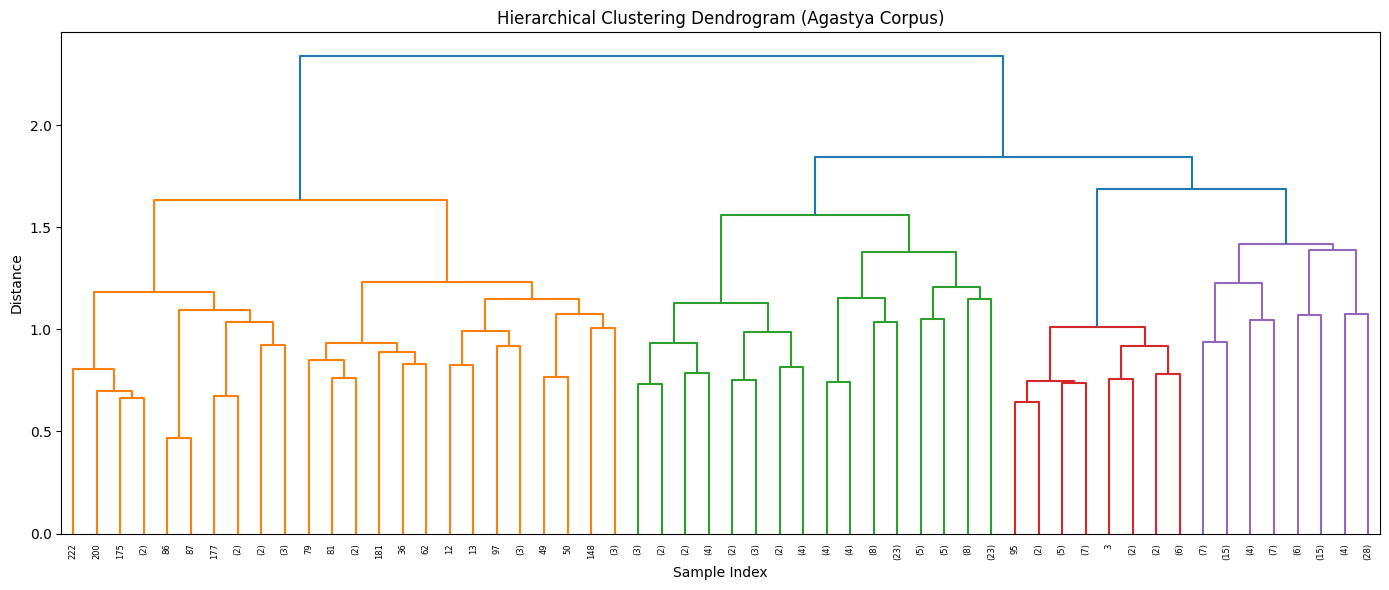

In [67]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Assuming agastya_embeddings is a numpy array
Z = linkage(agastya_embeddings, method='ward', metric='euclidean')  # or cosine, single/complete/average linkage

plt.figure(figsize=(14, 6))
dendrogram(Z, truncate_mode='level', p=5, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (Agastya Corpus)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [68]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Re-define cluster_texts for a specific cluster (e.g., Cluster 1) for LDA
# This assumes 'labels' and 'agastya_corpus' are available from previous cells.
# You might want to choose a different cluster or make this dynamic if needed.
selected_cluster_id = 1 # Example: using cluster 1, which has 41 items
cluster_texts = [agastya_corpus[i] for i, l in enumerate(labels) if l == selected_cluster_id]

# Add a check to ensure there are enough documents for LDA
min_docs_for_lda = 2 # This should be at least min_df, and ideally more for meaningful topics
if len(cluster_texts) < min_docs_for_lda:
    print(f"Warning: Cluster {selected_cluster_id} has only {len(cluster_texts)} documents, which is less than the minimum required ({min_docs_for_lda}) for LDA. Skipping LDA for this cluster or adjusting min_df.")
    # Optionally, you can skip LDA or adjust min_df here
    # For now, we will skip if there aren't enough documents
else:
    vectorizer = CountVectorizer(max_df=0.8, min_df=2, stop_words=custom_stopwords)
    X_counts = vectorizer.fit_transform(cluster_texts)
    lda = LatentDirichletAllocation(n_components=3, random_state=42)
    lda.fit(X_counts)

    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx}: ", [feature_names[i] for i in topic.argsort()[:-11:-1]])


Topic 0:  ['along', 'had', 'hearing', 'him', 'यस', 'अगस', 'सह', 'son', 'come', 'तत']
Topic 1:  ['having', 'highly', 'effulgent', 'thereupon', 'तम', 'being', 'honoured', 'तद', 'again', 'तत']
Topic 2:  ['great', 'again', 'having', 'saint', 'foremost', 'do', 'down', 'those', 'highly', 'addressed']


In [69]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# For a large cluster, e.g. cluster_texts from earlier code
vectorizer = CountVectorizer(max_df=0.8, min_df=2, stop_words=custom_stopwords)
X_counts = vectorizer.fit_transform(cluster_texts)  # cluster_texts = [text for idx in indices]
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X_counts)

feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}: ", [feature_names[i] for i in topic.argsort()[:-11:-1]])


Topic 0:  ['along', 'had', 'hearing', 'him', 'यस', 'अगस', 'सह', 'son', 'come', 'तत']
Topic 1:  ['having', 'highly', 'effulgent', 'thereupon', 'तम', 'being', 'honoured', 'तद', 'again', 'तत']
Topic 2:  ['great', 'again', 'having', 'saint', 'foremost', 'do', 'down', 'those', 'highly', 'addressed']


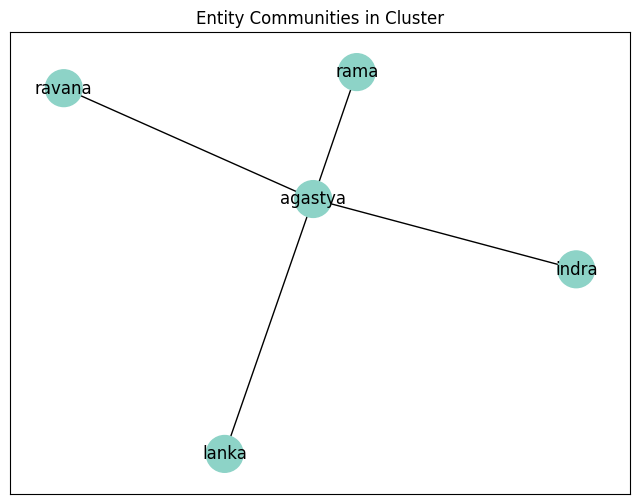

In [75]:
# Install python-louvain library if not already installed
!pip install python-louvain

import networkx as nx

# Use your entity extraction logic per cluster
G = nx.Graph()
for text in cluster_texts:
    entities = extract_entities(text)
    for i, e1 in enumerate(entities):
        for e2 in entities[i+1:]:
            G.add_edge(e1, e2, weight=G.get_edge_data(e1, e2, default={'weight': 0})['weight'] + 1)

# Louvain community detection
from community import community_louvain
partition = community_louvain.best_partition(G)

# Visualize communities
pos = nx.spring_layout(G)
plt.figure(figsize=(8,6))
nx.draw_networkx(G, pos, node_color=[partition.get(n, 0) for n in G.nodes()],
                 cmap=plt.cm.Set3, with_labels=True, node_size=700)
plt.title("Entity Communities in Cluster")
plt.show()

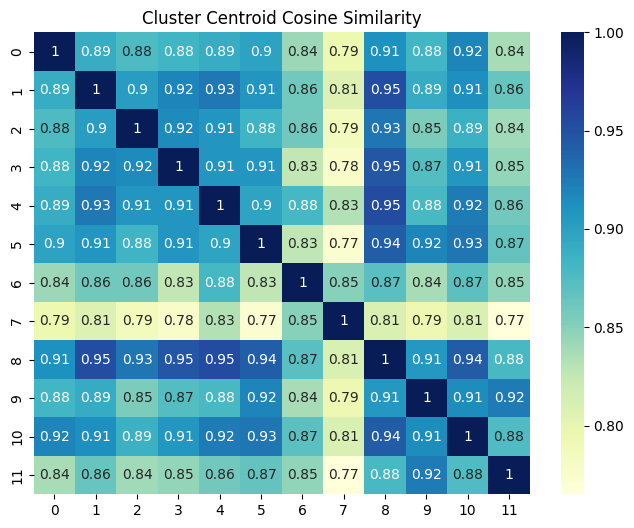

In [72]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt # Import matplotlib for plt.show()

centroids = []
for label in set(labels):
    if label == -1: continue
    mask = (labels == label)
    # Use embeddings_np (the NumPy array version) instead of agastya_embeddings
    centroids.append(embeddings_np[mask].mean(axis=0))
centroids = np.array(centroids)

# Ensure there are enough centroids to compute similarity (at least 2 clusters)
if len(centroids) > 1:
    similarity = np.dot(centroids, centroids.T) / (np.linalg.norm(centroids, axis=1, keepdims=True) @ np.linalg.norm(centroids, axis=1, keepdims=True).T)
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity, annot=True, cmap="YlGnBu")
    plt.title("Cluster Centroid Cosine Similarity")
    plt.show()
else:
    print("Not enough clusters (at least 2) to compute and visualize centroid similarity.")
